<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/TriggerEfficiencyMeasurement_fromNanoAODonSWAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Photon trigger efficiency measurement for EWK $\gamma$jj measurement

### Author: Pedro Vieira de Castro Ferreira Da Silva ( Pedro.Silva@cern.ch )


## First part: event selection and data preparation

This first part takes a long time to run (order 4h for full RunII) and just needs to be executed once to gather the inputs needed for the trigger efficiency measurement.

In [ ]:
#uncomment if you need to install something missing
#!pip install --user tqdm

In [ ]:
import os
import re
import tables as tb
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

!mkdir -p data/Chunks

In [ ]:
import numpy as np
import pandas as pd
import ROOT
import PyRDF

def getTriggersFor(era,isMC):
    
    """ returns the trigger list for a given era """
    
    trigs=[]
    if '2016' in era:
        trigs=['HLT_Photon75_R9Id90_HE10_Iso40_EBOnly_VBF',
               'HLT_Photon50',
               'HLT_Photon50_R9Id90_HE10_IsoM',
               'HLT_Photon75_R9Id90_HE10_IsoM',
               'HLT_Photon175',                            
               'HLT_Photon90']
    if '2017' in era:
        trigs=['HLT_Photon200',
               'HLT_Photon150']
        if '2017_F' in era or isMC:
            trigs += ['HLT_Photon75_R9Id90_HE10_IsoM_EBOnly_PFJetsMJJ300DEta3',
                      'HLT_Photon50_R9Id90_HE10_IsoM',
                      'HLT_Photon75_R9Id90_HE10_IsoM']
    if '2018' in era:
        trigs=['HLT_Photon75_R9Id90_HE10_IsoM_EBOnly_PFJetsMJJ300DEta3',
               'HLT_Photon50',
               'HLT_Photon50_R9Id90_HE10_IsoM',
               'HLT_Photon200',
               'HLT_Photon90']
        
    return trigs


def defineSelectionAndBranches(files,era,isData,local=False):

    """
    wraps the procedure of selecting the events and collecting the necessary info in a small dataframe
    returns a pandas DataFrame
    """
    
    if local:
        ROOT.ROOT.EnableImplicitMT()
        PyRDF.use('local')
    else:
        PyRDF.use('spark', {'npartitions':12})
        files = ['root://eosuser.cern.ch/{}'.format(x) if x.find('root:')<0 else x for x in files]
    
    PyRDF.include_headers("snippets/kinematics_helpers.h")
    
    #define the selections and branches with an RDataFrame
    rdf = PyRDF.RDataFrame("Events", files)

    branchList=['run','PV_npvsGood']
    if not isData:
        branchList += ['genWeight','puWeight']

    #trigger selection (require at least one fired)
    trigs=getTriggersFor(era,False if isData else True)
    triggerBranches=[]
    for t in trigs:
        b='Pass_{}'.format(t)
        rdf=rdf.Define(b, 'int({}==1)'.format(t) )
        triggerBranches.append(b)
    trigFilt='+'.join(triggerBranches)+'>0'
    rdf=rdf.Filter(trigFilt,'Trigger')
    branchList+=triggerBranches

    #photon selection
    good_photon  = 'Photon_pt>50 && (Photon_isScEtaEB==1 || Photon_isScEtaEE==1)'      #kinematics
    good_photon += '&& Photon_cutBased==3 && Photon_pixelSeed==0'                      #identification
    rdf = rdf.Define('good_photon',good_photon) \
             .Define('na','Sum(good_photon)') \
             .Filter('na>0','Photon selection')
    photonBranches=['pt','eta','phi','isScEtaEB']
    for attr in photonBranches:
        if attr=='isScEtaEB':
            rdf=rdf.Define(attr,'int(Photon_{}[good_photon][0])'.format(attr))
        else:
            rdf=rdf.Define(attr,'Photon_{}[good_photon][0]'.format(attr))            
    branchList += photonBranches
    
    #jet selection
    good_jet  = 'Jet_pt>30 && abs(Jet_eta)<4.7'                                 #kinematics
    #good_jet += ' && sqrt(pow(eta-Jet_eta,2)+pow(DeltaPhi(phi,Jet_phi),2))>0.4' #cross clean to photon candidate
    good_jet += ' && crossClean(Jet_eta,Jet_phi,eta,phi)'                       #cross clean to photon candidate
    good_jet += ' && Jet_puId>6'                                                #pileup id (loose bit activ)
    if '2016' in era:
        good_jet += ' && Jet_jetId>0'                                           #loose id
    if '2017' in era:
        good_jet += ' && Jet_jetId>1'                                           #tight lep veto and ECAL noise       
        good_jet += ' && !(abs(Jet_eta)>2.650 && abs(Jet_eta)<3.139 && (Jet_chEmEF+Jet_neEmEF>0.55))'    
    if '2018' in era:
        good_jet += ' && Jet_jetId>1'                                           #tight lep veto and HEM 15/16 failure
        good_jet += ' && !(Jet_eta>-3.0 && Jet_eta<-1.3 && Jet_phi>-1.57 && Jet_phi<-0.87)'
    rdf = rdf.Define('good_jet',good_jet) \
             .Define('nj','Sum(good_jet)') \
             .Define('ptj1','nj>0 ? Jet_pt[good_jet][0] : -9999.') \
             .Define('ptj2','nj>1 ? Jet_pt[good_jet][1] : -9999.') \
             .Define('detajj','nj>1 ? Jet_eta[good_jet][0]-Jet_eta[good_jet][1]: -9999.') \
             .Define('detaaj1','nj>0 && na>0 ? Jet_eta[good_jet][0]-Photon_eta[good_photon][0] : -9999.') \
             .Define('detaaj2','nj>1 && na>0 ? Jet_eta[good_jet][1]-Photon_eta[good_photon][0] : -9999.') \
             .Define('mjj','GetPairInvariantMass(Jet_pt[good_jet], Jet_eta[good_jet], Jet_phi[good_jet], Jet_mass[good_jet], 0, 1)') \
             .Define('maj1','GetInvariantMassWithConstantM(Jet_pt[good_jet], Jet_eta[good_jet], Jet_phi[good_jet], Jet_mass[good_jet],Photon_pt[good_photon],Photon_eta[good_photon],Photon_phi[good_photon],0.,0,0)') \
             .Define('maj2','GetInvariantMassWithConstantM(Jet_pt[good_jet], Jet_eta[good_jet], Jet_phi[good_jet], Jet_mass[good_jet],Photon_pt[good_photon],Photon_eta[good_photon],Photon_phi[good_photon],0.,1,0)')
    branchList += ['nj','ptj1','ptj2','detajj','detaaj1','detaaj2','mjj','maj1','maj2']

    #all done here
    return rdf,branchList

Collect the information about the samples of interest: list of samples to files.

In [ ]:
#build the list of selection tasks
#from snippets.file_helpers import collectInputs

PATHS=['/eos/cms/store/cmst3/group/top/SMP-19-005/july20/SinglePhoton/',
       '/eos/cms/store/cmst3/group/top/SMP-19-005/july20/EGamma/',
       '/eos/cms/store/cmst3/group/top/SMP-19-005/july20/GJets_SM_5f_TuneCH3_EWK_13TeV-madgraph-herwig7',
       '/eos/cms/store/cmst3/group/top/SMP-19-005/july20/GJets_SM_5f_TuneCUETP8M1_EWK_13TeV-madgraph-pythia8',
       '/eos/cms/store/cmst3/group/top/SMP-19-005/july20/GJets_SM_5f_TuneEE5C_EWK_13TeV-madgraph-herwigpp',
       '/eos/cms/store/cmst3/group/top/SMP-19-005/july20/GJets_SM_5f_TuneCP5_EWK_13TeV-madgraph-pythia8',
      ]

samples_list=collectInputs(PATHS)
                
print('I have collected a total of {} tasks'.format(len(samples_list)))
print(list(samples_list.keys()))

### Event selection

The following cell defines methods to steer the event selection and saving a summary of the trigger efficiency measurement.

In [ ]:
from snippets.selection_helpers import *

def getSnapshot(files,era,isData,local=False,saveSnapshot=None):
  
    """applies the selection to save a ROOT snapshot or get the summary as a pandas dataframe"""

    rdf,branchList = defineSelectionAndBranches(files,era,isData,local)
    
    #save as a snapshot?
    if saveSnapshot:
        vec_outbranchlist = ROOT.vector('string')()
        [vec_outbranchlist.push_back(b) for b in branchList]
        rdf.Snapshot('Events',saveSnapshot,vec_outbranchlist)
    
    return pd.DataFrame(rdf.AsNumpy(columns=branchList))

Test locally for one sample (not mandatory to evaluate - do it if you need to test some change in the selection code)

In [ ]:
#sample='crab_SinglePhoton_2016_B_v2'
#isData=True
sample='crab_GJets_SM_5f_TuneCP5_EWK_13TeV-madgraph-pythia8_2017_ext1_v1'
isData=False
f=samples_list[sample][0:2]
df=getSnapshot(f,sample,isData=isData,local=False)
print('Dataframe has Nan?',df.isnull().values.any(),'shape=',df.shape)
df.head()

Loop over all the samples to process them using multithreading and spark

In [ ]:
%timeit

def runSelectionTask(args):

    """runs the selection tasks on a given file/set of files"""
    try:
        era,files,force,local = args
    
        #if output has been produced
        out_file='data/Chunks/{}.h5'.format(era)
        if os.path.isfile(out_file) and not force:
            return
        
        #process files using spark
        isData=False if 'GJets' in era else True
        df=getSnapshot(files,era,isData=isData,local=local)

        #save result
        df.to_hdf(out_file,key='Events',mode='w')
    except Exception as e:
        print('@ {} failed -better check locally'.format(era))
        print(e)
        return False
    
    return True
        
    
def runTasks(tasks_to_run,force=False,ngroup=10,local=False):

    """
    loop over the tasks and submit the analysis in groups of ngroups
    force is used to force the re-creation of the summary files
    nthreads is used to determine the number of threads used to submit the analysis of each task
    """
    
    #loop over tasks
    for task,files in tasks_to_run:
        
        #sub-divide per file
        sub_task_list=[]
        for i in range(0, len(files),ngroup):
            args=('{}_{}'.format(task,i),files[i:i+ngroup],force,local)
            runSelectionTask(args)

tasks_to_run=list(samples_list.items())
runTasks(tasks_to_run=tasks_to_run,
         force=False,
         ngroup=10,
         local=False)

In [ ]:
#create the merged files per task
%timeit
from snippets.file_helpers import mergeChunkFiles
mergeChunkFiles('data/Chunks','data/Merged')

## Second part: trigger efficiency measurement

In the following we make use of the merged .h5 summary files which were created above. No need to evaluate the cells above for the final results. The configuration of the trigger efficiency measurements is made through the dicts defined in snippets/trig_helpers.py

In [ ]:
%load_ext autoreload
%autoreload 2

from snippets.trig_helpers import *
from snippets.math_helpers import getEfficiency,getScaleFactor
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import numpy as np


#uncomment the line if you want to visualize the available definitions to use
#getTrigMeasurementDefinitions()


def defineSelectionMasks(df,trig,mask_cuts):

    """define the selection to apply"""
    
    mask=(df['Pass_'+trig]==1) & (df['pt']>mask_cuts['pt']) & (df['PV_npvsGood']>0)
    if 'isScEtaEB' in mask_cuts: mask=mask & (df['isScEtaEB']==mask_cuts['isScEtaEB'])
    if 'mjj'       in mask_cuts: mask=mask & (df['mjj']>mask_cuts['mjj'])
    if 'detajj'    in mask_cuts: mask=mask & (np.abs(df['detajj'])>mask_cuts['detajj'])
    if 'ptj1'      in mask_cuts: mask=mask & (np.abs(df['ptj1'])>mask_cuts['ptj1'])
    if 'ptj2'      in mask_cuts: mask=mask & (np.abs(df['ptj2'])>mask_cuts['ptj2'])
    if 'run'       in mask_cuts: mask=mask & (df['run']>mask_cuts['run'][0]) & (df['run']<mask_cuts['run'][1])
                
    return mask

def computeEfficiency(df,v,trig,ctrl_trig,mask_cuts,bins=25,isWeighted=False):
    
    """wraps up the computation of the efficiency"""

    #get the masks to apply
    #in the numerator require also the control trigger
    mask_num=defineSelectionMasks(df,trig,mask_cuts)
    mask_num &= (df['Pass_'+ctrl_trig])==1
    mask_den=defineSelectionMasks(df,ctrl_trig,mask_cuts)
    
    #define the final binning by percentile
    if isinstance(v,list):
        if isinstance(bins[0],int):
            finalBins=[]
            for i in range(2):
                iv=v[i]
                ib=bins[i]
                finalBins.append( np.percentile(df[mask_den][iv], np.linspace(0,100,ib)) )
            bins=finalBins
    elif isinstance(bins,int):
        bins  = np.percentile(df[mask_den][v], np.linspace(0,100,bins))

    #measure the efficiency
    method='normal' if isWeighted else 'beta'
    pts,eff,deff=getEfficiency(df,v,mask_den,mask_num,bins,method=method,alpha=0.683)

    return bins,pts,eff,deff


def showEfficiencyMeasurementSummary(eff_results,sf_results,xtitle,ptitle,cuts,scale,outname):

    """plots the efficiencies and the scale factors"""

    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,6))
    
    #MCs
    for mc in eff_results['mc']:
        mctitle,bins,x,dx,eff,deff=eff_results['mc'][mc]
        ax1.errorbar(x,eff,deff, fmt='-',label=r'%s'%mctitle)        
        for d2mc in sf_results['mc'][mc]:
            dtitle,sf,dsf=sf_results['mc'][mc][d2mc]
            ax2.errorbar(x,sf,dsf,fmt='o',label=r'%s/%s'%(dtitle,mctitle),markersize=10)        
            
    #Data
    for d in eff_results['data']:
        dtitle,bins,x,dx,eff,deff=eff_results['data'][d]
        ax1.errorbar(x,eff,deff, fmt='o',label=r'%s'%dtitle,markersize=10)

    ax1.grid()
    ax1.legend(loc='lower right',fontsize=12)
    ax1.set_ylabel('Efficiency',fontsize=12)
    ax1.set_ylim(0,1)
    ax1.text(0,1.02,'CMS', transform=ax1.transAxes,weight='bold',fontsize=14)
    ax1.text(0.08,1.02,'Preliminary', transform=ax1.transAxes,fontsize=14)

    ax1.text(0.5,1.02,ptitle, transform=ax1.transAxes,ha='center',fontsize=12)
    i=0
    for v,cv in cuts.items():
        ctitle='{}>{}'.format(v,cv)
        if v=='isScEtaEB': ctitle='EB={}'.format(cv)
        if v=='run': ctitle='{}<run<{}'.format(*cv)
        ax1.text(0.05,0.47-i*0.07,ctitle, transform=ax1.transAxes,ha='left',fontsize=10)
        i+=1

    ax2.set_ylabel('Scale factor',fontsize=12)
    ax2.set_xlabel(xtitle)
    ax2.set_ylim(0.7,1.05)
    ax2.grid()

    fig.tight_layout()
    plt.savefig(outname)
    plt.close()
    
    
def showEfficiencyMeasurementSummary2D(eff_results,sf_results,xtitle,ytitle,ptitle,cuts,scale,outname):

    """plots the efficiencies and the scale factors"""

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex='col', sharey='row', gridspec_kw={'wspace': 0.05,'hspace':0.02},figsize=(16,5))
        
    cmap='coolwarm'
    scale=scale.split(':')
        
    #first MC
    keymc=list(eff_results['mc'].keys())[0]
    mctitle,bins,pts,eff,deff=eff_results['mc'][keymc]
    xedges,yedges=pts[0],pts[2]
    X, Y = np.meshgrid(xedges, yedges)
    ax1.pcolormesh(X, Y, eff,cmap=cmap,vmin=0.6, vmax=1.05)
    ax1.grid()
    ax1.text(0.95,0.95, r'%s'%mctitle, transform=ax1.transAxes, fontsize=12, ha='right')
    ax1.set_xlabel(xtitle,fontsize=12)
    ax1.set_ylabel(ytitle,fontsize=12)
    ax1.set_xscale(scale[0])
    ax1.set_yscale(scale[1])

    #first data
    keydata=list(eff_results['data'].keys())[0]
    datatitle,_,_,eff,deff=eff_results['data'][keydata]
    ax2.pcolormesh(X, Y, eff,cmap=cmap,vmin=0.6, vmax=1.05)
    ax2.grid()
    ax2.text(0.95,0.95, r'%s'%datatitle, transform=ax2.transAxes, fontsize=12, ha='right')
    ax2.set_xlabel(xtitle,fontsize=12)
    ax2.set_xscale(scale[0])
    ax2.set_yscale(scale[1])
    
    #first SF
    _,sf,dsf=sf_results['mc'][keymc][keydata]
    pcm=ax3.pcolormesh(X, Y, sf,cmap=cmap,vmin=0.6, vmax=1.05)
    ax3.grid()
    ax3.text(0.95,0.95,r'%s/%s'%(datatitle,mctitle),transform=ax3.transAxes, fontsize=12, ha='right')
    ax3.set_xlabel(xtitle,fontsize=12)
    ax3.set_xscale(scale[0])
    ax3.set_yscale(scale[1])


    i=0
    for v,cv in cuts.items():
        ctitle='{}>{}'.format(v,cv)
        if v=='isScEtaEB': ctitle='EB={}'.format(cv)
        if v=='run': ctitle='{}<run<{}'.format(*cv)
        ax1.text(0.05,0.9-i*0.07,ctitle, transform=ax1.transAxes,ha='left',fontsize=10)
        i+=1


    cax = inset_axes(ax3,
                     width="5%",
                     height="100%",
                     loc='right',
                     bbox_to_anchor=(0.1,0.0, 1.,1.),
                     bbox_transform=ax3.transAxes)
    cbar=fig.colorbar(pcm,cax=cax,orientation="vertical")
    cbar.set_label('Efficency or scale factor', rotation=270, labelpad=10)

    ax1.text(0,1.02,   'CMS',         transform=ax1.transAxes, fontsize=14, weight='bold')
    ax1.text(0.12,1.02, 'Preliminary', transform=ax1.transAxes, fontsize=14)
    ax2.text(0.5,1.02,  ptitle,       transform=ax2.transAxes, fontsize=12, ha='center')


    plt.show()
    #plt.savefig(outname)
    #plt.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


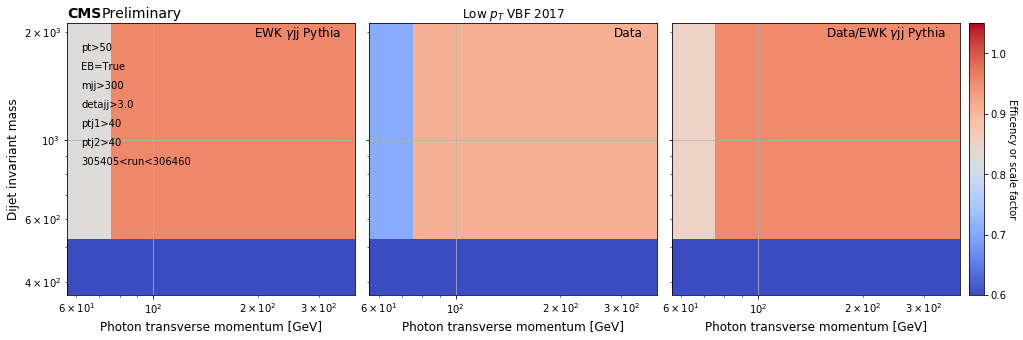

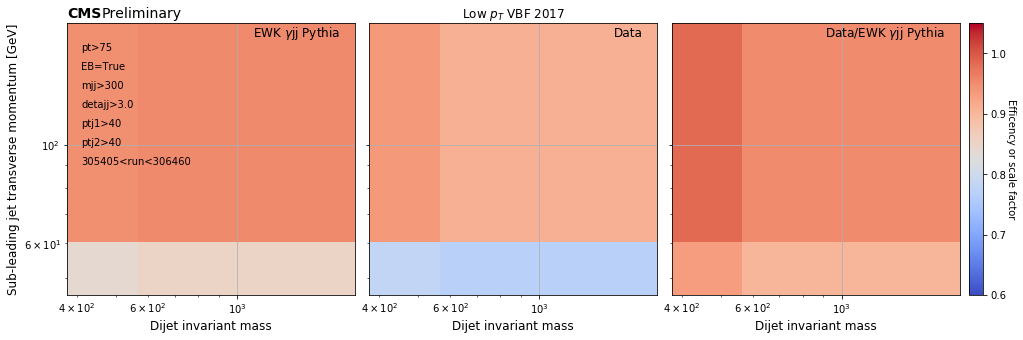

Find all plots in /eos/user/p/psilva/www/SMP-19-005/trig/2020Oct13


In [ ]:
import copy

def steerTriggerEfficiencyMeasurement(cfg,data,outbase):

    """
    reads the required datasets for the measurement and calls the base methods for the trigger efficiency measurement
    the inputs are two dicts containing the required parameters to configure the data and the measurement (trigger names, cuts etc.)
    """
    
    df={}
    for key,samples_list in data.items():
        df[key]=[]
        for name,descr in samples_list.items():
            dfs=[]
            for f in descr['chunks']:
                dfs.append( pd.read_hdf(f,key='Events') )
            merged_df=pd.concat(dfs,sort=False)
            merged_df['absdetajj']=np.abs(merged_df['detajj'])
            df[key].append( (name,descr['title'],merged_df) )
        
   
    #loop over the variables to profile
    for v,v_cfg in cfg['vars'].items():

        is2D=False
        if ':' in v:
            v=v.split(':')
            is2D=True
            
        #loop over the datasets and define the masks needed for this variable 
        #then run the efficiency measurement
        #the binning is set by the quantiles of the data distribution which is run first
        eff_results={}
        sf_results={}
        bins=None
        for key in ['data','mc']:
            samples=df[key]
            eff_results[key]={}
            sf_results[key]={}
            for iname,ititle,idf in samples:
                                    
                if bins is None: bins=v_cfg['bins']
                    
                mask_cuts=copy.deepcopy(v_cfg['mask_cuts'])

                if key=='data' and 'lpt2017' in outbase: mask_cuts['run']=[305405,306460]
                 
                #efficiency
                bins,pts,eff,deff=computeEfficiency(idf,
                                                    v,
                                                    trig=cfg['trig'],
                                                    ctrl_trig=cfg['ctrl'],
                                                    mask_cuts=mask_cuts,
                                                    bins=bins)
                
                eff_results[key][iname]=(ititle,bins,pts,eff,deff)
                
                #compute data/MC scale factors
                if key=='data': continue
                sf_results[key][iname]={}
                for dname,d in eff_results['data'].items():
                    dtitle,eff_data,deff_data=d[0],d[3],d[4]
                    sf,dsf = getScaleFactor(eff_data,deff_data,eff,deff)
                    sf_results[key][iname][dname]=(dtitle,sf,dsf)
                 
        #show a summary plot
        outname=outbase+'_{}.png'.format(v)
        mask_cuts=copy.deepcopy(v_cfg['mask_cuts'])
        if 'lpt2017' in outname: mask_cuts['run']=[305405,306460]
            
        if not is2D:
            showEfficiencyMeasurementSummary(eff_results=eff_results,
                                             sf_results=sf_results,
                                             xtitle=var_dict[v],
                                             ptitle=cfg['title'],
                                             cuts=mask_cuts,
                                             scale=v_cfg['scale'],
                                             outname=outname)
        else:
            showEfficiencyMeasurementSummary2D(eff_results=eff_results,
                                               sf_results=sf_results,
                                               xtitle=var_dict[v[0]],
                                               ytitle=var_dict[v[1]],
                                               ptitle=cfg['title'],
                                               cuts=mask_cuts,
                                               scale=v_cfg['scale'],
                                               outname=outname)
        
import os
import datetime
outdir='/eos/user/p/psilva/www/SMP-19-005/trig/{}'.format(datetime.datetime.now().strftime('%Y%b%d'))
os.system('mkdir -p {}'.format(outdir))

#steerTriggerEfficiencyMeasurement(trig_eff_measurements['hpt2016'], data_for_trig_eff['2016'],  outdir+'/hpt2016')
#steerTriggerEfficiencyMeasurement(trig_eff_measurements['hpt2017'], data_for_trig_eff['2017'],  outdir+'/hpt2017')
#steerTriggerEfficiencyMeasurement(trig_eff_measurements['hpt2018'], data_for_trig_eff['2018'],  outdir+'/hpt2018')

#steerTriggerEfficiencyMeasurement(trig_eff_measurements['lpt2016'], data_for_trig_eff['2016'], outdir+'/lpt2016')
steerTriggerEfficiencyMeasurement(trig_eff_measurements['lpt2017'], data_for_trig_eff['2017F'], outdir+'/lpt2017')
#steerTriggerEfficiencyMeasurement(trig_eff_measurements['lpt2018'], data_for_trig_eff['2018'], outdir+'/lpt2018')

print('Find all plots in',outdir)